In [1]:
using Revise

In [2]:
include("gp_utility.jl")

plot_gp_realizations (generic function with 1 method)

In [3]:
using CmdStan
using CmdStanExtract

using DataFrames
using Plots

In [4]:
using Serialization

In [5]:
using ColorSchemes
using Statistics

In [6]:
alpha_true = 3
rho_true = 5.5
sigma_true = 2

N_total = 501
x_total = 20 * (0:(N_total - 1)) / (N_total - 1) .- 10

simu_data = Dict("alpha" => alpha_true, "rho" => rho_true, "sigma" => sigma_true,
                  "N" => N_total, "x" => x_total)

Dict{String,Any} with 5 entries:
  "sigma" => 2
  "alpha" => 3
  "N"     => 501
  "x"     => -10.0:0.04:10.0
  "rho"   => 5.5

In [7]:
simu_gauss = "
data {
  int<lower=1> N;
  real x[N];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

transformed data {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
  matrix[N, N] L_cov = cholesky_decompose(cov);
}

parameters {}
model {}

generated quantities {
  vector[N] f = multi_normal_cholesky_rng(rep_vector(0, N), L_cov);
  vector[N] y;
  for (n in 1:N)
    y[n] = normal_rng(f[n], sigma);
}
"
;

In [8]:
stanmodel = Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="simu_gauss", model=simu_gauss, nchains=1, num_samples=1, random=CmdStan.Random(494838),
);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/simu_gauss.stan will be updated.



In [9]:
simu_fit = stan(stanmodel, simu_data, summary=false)

(0, [0.0 0.0 … -3.15261 -1.23523], ["lp__", "accept_stat__", "f.1", "f.2", "f.3", "f.4", "f.5", "f.6", "f.7", "f.8"  …  "y.492", "y.493", "y.494", "y.495", "y.496", "y.497", "y.498", "y.499", "y.500", "y.501"])

In [10]:
par_simu_fit = extract(simu_fit)

Dict{String,Array} with 4 entries:
  "f"             => [0.440999; 0.450114; … ; -1.00529; -1.00435]
  "lp__"          => [0.0]
  "accept_stat__" => [0.0]
  "y"             => [-0.305988; 3.34174; … ; -3.15261; -1.23523]

In [11]:
f_total = par_simu_fit["f"][:,1,1]
y_total = par_simu_fit["y"][:,1,1]

true_realization = DataFrame("f_total" => f_total, "x_total" => x_total)

head(true_realization)

,f_total,x_total
,Float64,Float64
1,0.440999,-10.0
2,0.450114,-9.96
3,0.459221,-9.92
4,0.468386,-9.88
5,0.477522,-9.84
6,0.486707,-9.8


In [12]:
true_realization = DataFrame("f_total" => f_total, "x_total" => x_total)

observed_idx = 50*(0:10).+1
N = length(observed_idx)
x = x_total[observed_idx]
y = y_total[observed_idx]
;

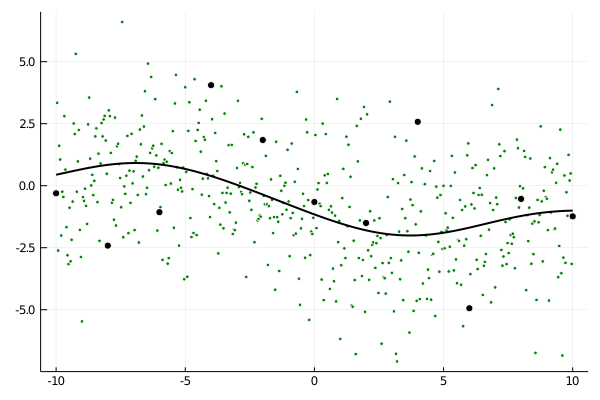

In [13]:
plot(legend=false)
scatter_total!(x_total, y_total)
plot_main!(x_total, f_total)
scatter_obs!(x, y)

In [14]:
N_predict = N_total
x_predict = x_total
y_predict = y_total
;

In [15]:
serialize("gp.data", (;N, x, y, N_predict, x_predict, y_predict)) # this line requires Julia 1.5

In [16]:
data = deserialize("gp.data")

(N = 11, x = -10.0:2.0:10.0, y = [-0.305988, -2.4159, -1.06836, 4.05275, 1.84246, -0.656602, -1.50408, 2.57574, -4.94042, -0.533326, -1.23523], N_predict = 501, x_predict = -10.0:0.04:10.0, y_predict = [-0.305988, 3.34174, -2.6149, 1.61098, 1.05581, -2.00876, -0.240148, -0.453517, 2.8017, 0.648663  …  -2.89914, 0.412148, -3.11129, -0.265462, -1.21106, 1.2445, 0.210053, 0.494353, -3.15261, -1.23523])

In [17]:
serialize("gp.truth", (;f_total, x_total, sigma_true))

In [18]:
f_data = Dict("sigma" => sigma_true, "N" => N_total, "f" => f_total)

Dict{String,Any} with 3 entries:
  "sigma" => 2
  "f"     => [0.440999, 0.450114, 0.459221, 0.468386, 0.477522, 0.486707, 0.495…
  "N"     => 501

In [19]:
# https://github.com/betanalpha/knitr_case_studies/blob/master/gaussian_processes/gp_part1/simu_gauss_dgp.stan
# dgp -> data generative process

simu_gauss_dgp = "
data {
  int<lower=1> N;
  real f[N];
  real<lower=0> sigma;
}

parameters {}
model {}

generated quantities {
  vector[N] y_predict;
  for (n in 1:N)
    y_predict[n] = normal_rng(f[n], sigma);
}
"
;

In [20]:
dgp_stanmodel = Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="simu_gauss_dgp", model=simu_gauss_dgp, nchains=1, num_samples=1000, random=CmdStan.Random(5838298)
)

dgp_fit = stan(dgp_stanmodel, f_data, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/simu_gauss_dgp.stan will be updated.



In [21]:
dgp_par = extract(dgp_fit)

Dict{String,Array} with 3 entries:
  "lp__"          => [0.0; 0.0; … ; 0.0; 0.0]
  "accept_stat__" => [0.0; 0.0; … ; 0.0; 0.0]
  "y_predict"     => [0.208696 -0.153105 … -1.00077 -1.7667; -0.613258 1.17654 …

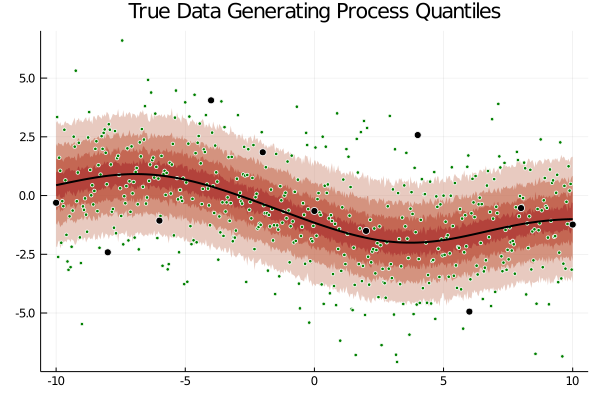

In [22]:
plot_gp_pred_quantiles(dgp_fit, data, true_realization, "True Data Generating Process Quantiles")

In [23]:
predict_gauss = "
functions {
  vector gp_pred_rng(real[] x2,
                     vector y1, real[] x1,
                     real alpha, real rho, real sigma, real delta) {
    int N1 = rows(y1);
    int N2 = size(x2);
    vector[N2] f2;
    {
      matrix[N1, N1] K =   cov_exp_quad(x1, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N1));
      matrix[N1, N1] L_K = cholesky_decompose(K);

      vector[N1] L_K_div_y1 = mdivide_left_tri_low(L_K, y1);
      vector[N1] K_div_y1 = mdivide_right_tri_low(L_K_div_y1', L_K)';
      matrix[N1, N2] k_x1_x2 = cov_exp_quad(x1, x2, alpha, rho);
      vector[N2] f2_mu = (k_x1_x2' * K_div_y1);
      matrix[N1, N2] v_pred = mdivide_left_tri_low(L_K, k_x1_x2);
      matrix[N2, N2] cov_f2 =   cov_exp_quad(x2, alpha, rho) - v_pred' * v_pred
                              + diag_matrix(rep_vector(delta, N2));
      f2 = multi_normal_rng(f2_mu, cov_f2);
    }
    return f2;
  }
}

data {
  int<lower=1> N;
  real x[N];
  vector[N] y;

  int<lower=1> N_predict;
  real x_predict[N_predict];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

transformed data {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
  matrix[N, N] L_cov = cholesky_decompose(cov);
}

parameters {}
model {}

generated quantities {
  vector[N_predict] f_predict = gp_pred_rng(x_predict, y, x, alpha, rho, sigma, 1e-10);
  vector[N_predict] y_predict;

  for (n in 1:N_predict)
    y_predict[n] = normal_rng(f_predict[n], sigma);
}
"

pred_gauss_data = Dict(
    "alpha" => alpha_true, "rho" => rho_true, "sigma" => sigma_true, 
    "N" => N, "x" => x, "y" => y,
    "N_predict" => N_predict, "x_predict" => x_predict
)

pred_gauss_stanmodel = Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="predict_gauss", model=predict_gauss, nchains=1, num_samples=1000, random=CmdStan.Random(5838298)
)

pred_fit = stan(pred_gauss_stanmodel, pred_gauss_data, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/predict_gauss.stan will be updated.



In [24]:
param_fit = extract(pred_fit)

Dict{String,Array} with 4 entries:
  "f_predict"     => [-1.12823 1.02393 … 0.641217 -0.661506; -1.12902 1.01541 ……
  "lp__"          => [0.0; 0.0; … ; 0.0; 0.0]
  "accept_stat__" => [0.0; 0.0; … ; 0.0; 0.0]
  "y_predict"     => [-1.72234 0.370045 … -1.82378 -2.96427; -0.40259 3.01343 ……

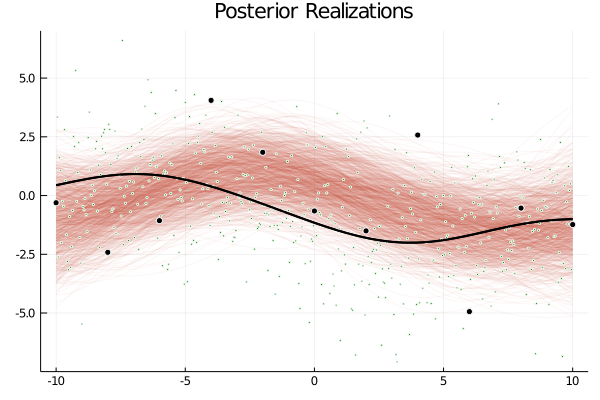

In [25]:
plot_gp_realizations(pred_fit, data, true_realization, "Posterior Realizations")

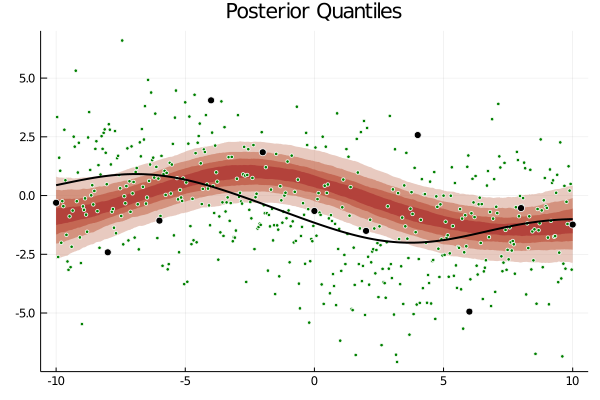

In [26]:
plot_gp_quantiles(pred_fit, data, true_realization, "Posterior Quantiles")


In [27]:
simu_poisson = "
data {
  int<lower=1> N;
  real x[N];

  real<lower=0> rho;
  real<lower=0> alpha;
}

transformed data {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
  matrix[N, N] L_cov = cholesky_decompose(cov);
}

parameters {}
model {}

generated quantities {
  vector[N] f = multi_normal_cholesky_rng(rep_vector(0, N), L_cov);
  int y[N];
  for (n in 1:N)
    y[n] = poisson_log_rng(f[n]);
}
"
;

In [28]:
#=
pred_gauss_data = Dict(
    "alpha" => alpha_true, "rho" => rho_true, "sigma" => sigma_true, 
    "N" => N, "x" => x, "y" => y,
    "N_predict" => N_predict, "x_predict" => x_predict
)
=#

simu_poisson_stanmodel = Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="simu_poisson", model=simu_poisson, nchains=1, num_samples=1, random=CmdStan.Random(494838)
)

simu_fit = stan(simu_poisson_stanmodel, simu_data, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/simu_poisson.stan will be updated.



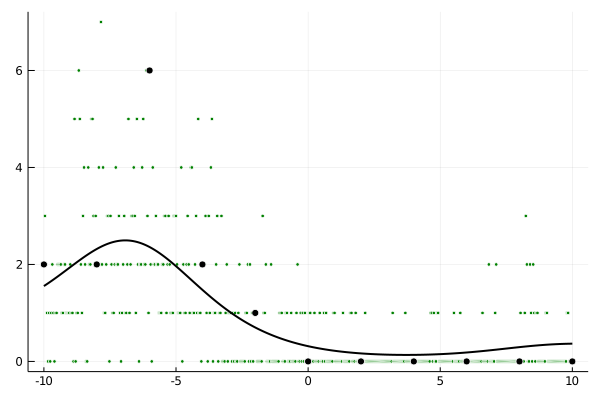

In [29]:
par_simu_fit = extract(simu_fit)

f_total = par_simu_fit["f"][:,1,1]
y_total = par_simu_fit["y"][:,1,1]

true_realization = DataFrame("f_total" => exp.(f_total), "x_total" => x_total)

observed_idx = 50*(0:10).+1
N = length(observed_idx)
x = x_total[observed_idx]
y = y_total[observed_idx]

data = (;N, x, y, N_predict, x_predict=x_total, y_predict=y_total)

plot(legend=false)
scatter_total!(x_total, y_total)
plot_main!(x_total, exp.(f_total))
scatter_obs!(x, y)

In [30]:
predict_poisson = "
data {
  int<lower=1> N_predict;
  real x_predict[N_predict];

  int<lower=1> N_observed;
  int<lower=1, upper=N_predict> observed_idx[N_observed];
  int y_observed[N_observed];

  real<lower=0> rho;
  real<lower=0> alpha;
}

transformed data {
  matrix[N_predict, N_predict] cov =   cov_exp_quad(x_predict, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N_predict));
  matrix[N_predict, N_predict] L_cov = cholesky_decompose(cov);
}

parameters {
  vector[N_predict] f_tilde;
}

transformed parameters {
  vector[N_predict] log_f_predict = L_cov * f_tilde;
}

model {
  f_tilde ~ normal(0, 1);
  y_observed ~ poisson_log(log_f_predict[observed_idx]);
}

generated quantities {
  vector[N_predict] f_predict = exp(log_f_predict);
  vector[N_predict] y_predict;
  for (n in 1:N_predict)
    y_predict[n] = poisson_log_rng(log_f_predict[n]);
}
"
;

In [31]:
pred_data = Dict(
    "alpha" => alpha_true, "rho" => rho_true,
    "N_predict" => N_predict, "x_predict" => x_predict,
    "N_observed" => N, "y_observed" => Int.(y), "observed_idx" => observed_idx
)


Dict{String,Any} with 7 entries:
  "x_predict"    => -10.0:0.04:10.0
  "N_observed"   => 11
  "y_observed"   => [2, 2, 6, 2, 1, 0, 0, 0, 0, 0, 0]
  "observed_idx" => 1:50:501
  "alpha"        => 3
  "N_predict"    => 501
  "rho"          => 5.5

In [32]:
pred_stanmodel = Stanmodel(
    # Sample(algorithm=CmdStan.Fixed_param()), 
    name="predict_poisson", model=predict_poisson, nchains=1, num_samples=1000, random=CmdStan.Random(5838298)
)

pred_fit = stan(pred_stanmodel, pred_data, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/predict_poisson.stan will be updated.



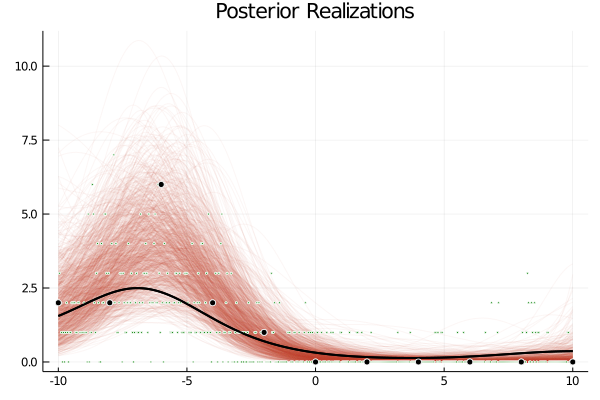

In [33]:
plot_gp_realizations(pred_fit, data, true_realization, "Posterior Realizations")

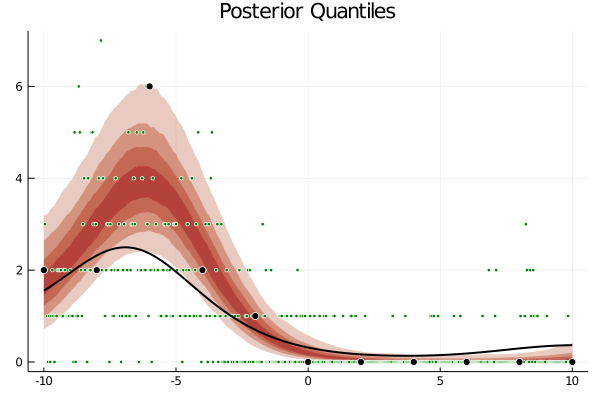

In [34]:
plot_gp_quantiles(pred_fit, data, true_realization, "Posterior Quantiles")

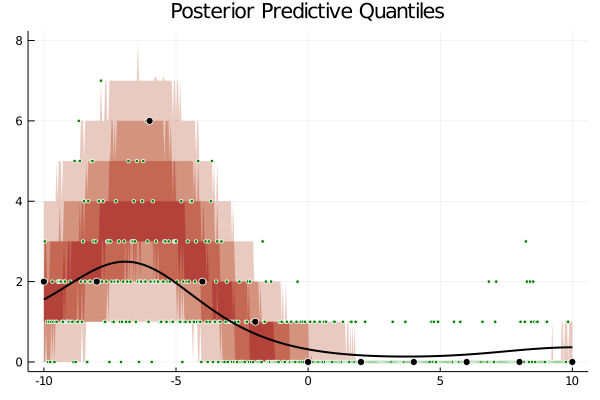

In [35]:
plot_gp_pred_quantiles(pred_fit, data, true_realization,
                  "Posterior Predictive Quantiles")
